# End-to-End Multi-Class Dog Breed Classification

Using TF 2.0 for multi class classification.

## 1. Problem
>Identifying the breed of a given dog by its image.

## 2. Data
Data from Kaggle competition : https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation
According to Kaggle :
>Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.

## 4. Features
* Our data is in form of images (unstructed data)
* We have 120 dog breed (120 class)
* Labels can be found on `labels.csv`
* Both training (with labaels) and test (without labels) sets have +10k image each

In [35]:
## Setup to import data directly from Kaggle
### Make sure to generate api key from your Kaggle account
### Import the json file here then run the following commands
### Uncomment the following to run

# ! pip install kaggle

# ! mkdir ~/.kaggle

# ! cp kaggle.json ~/.kaggle/

# ! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle competitions download -c dog-breed-identification

# ! unzip dog-breed-identification.zip -d data

## Workspace

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
%matplotlib inline
import seaborn as smb
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

In [3]:
# checking for gpu
if tf.config.list_physical_devices('GPU'):
  print('yes')
else:
  print('no')

yes


## Getting data Ready

In [4]:
# Checking labels
labels_csv = pd.read_csv('./data/labels.csv')

In [5]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [6]:
labels_csv

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


<Axes: >

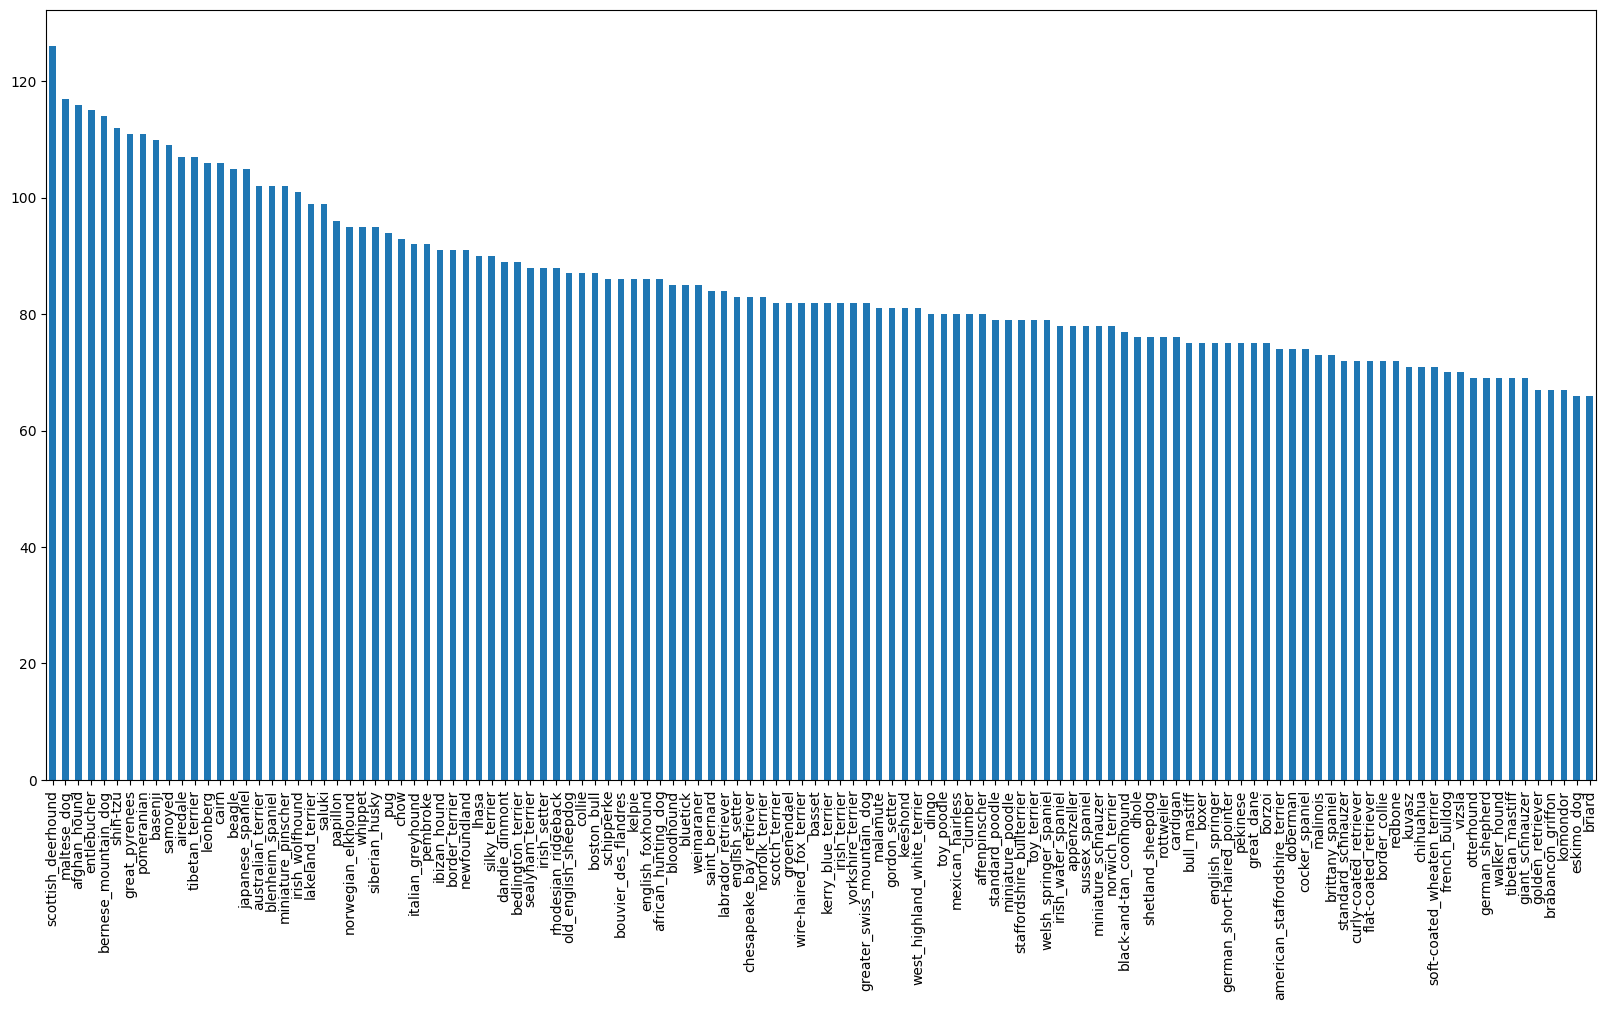

In [7]:
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10))

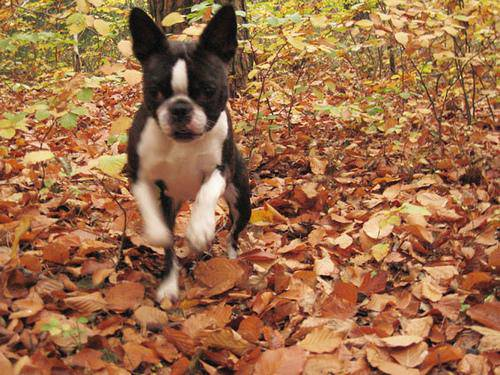

In [8]:
# Sample image
Image('./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg')

### Getting images and their labels

In [9]:
# Pathnames from img ID
filenames = ["./data/train/"+fname+".jpg" for fname in labels_csv['id']]

In [10]:
len(filenames)

10222

In [11]:
# import os
# if len(os.listdir('./data/train/'))== len(filenames):
#   print('good')

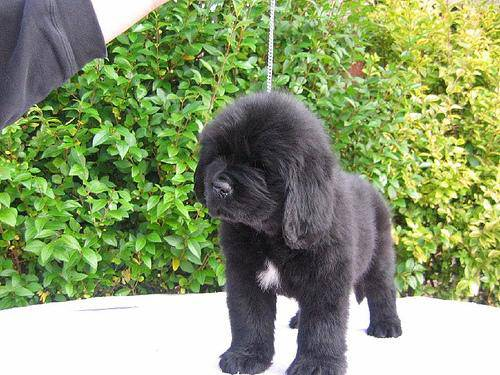

In [12]:
Image(filenames[420])

In [13]:
labels_csv['breed'][420]

'newfoundland'

In [14]:
# Getting the labels
labels = np.array(labels_csv['breed'])

In [15]:
len(labels)

10222

In [16]:
labels[420]

'newfoundland'

In [17]:
# Unique labels
unique_breeds= np.unique(labels)
len(unique_breeds)

120

In [18]:
# Turn every label to boolean array
def label_bool(labels, unique_breeds):
  boolean_labels = [label == unique_breeds for label in labels]
  return boolean_labels

In [19]:
boolean_labels= label_bool(labels, unique_breeds)
#boolean_labels[:3]

### Creating validation set

In [20]:
# Creating X / y
X = filenames
y = boolean_labels

We'll use 1000+- image initially 

In [21]:
# Portion of data for experimenting 
NUM_IMAGES = 1000 #@param {type: "slider", min: 1000, max: 10000, step:1000}

In [22]:
# Splitting data
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

### Preprocessing Images (truning images into tensors)
1. Take `filepath` as input
2. Use TF to read the file as it to a variable `image`
3. Turn `image` into tensors
4. Normalization, convert color channel from 0-255 to 0-1 (float)
5. Resize the `image` to (224,224)
6. Return the modified `image`

In [23]:
IMG_SIZE = 224
def process_image(image_path, img_size= IMG_SIZE):
  # Read the file
  image = tf.io.read_file(image_path)
  # Turn jpeg into num tensor with 3 color channels RGB
  image =  tf.image.decode_jpeg(image, channels = 3)
  # Convert color channel values from 0-255 to 0-1 (Normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize
  image = tf.image.resize(image, size=[img_size, img_size])
  return image

### Turning our data into batches

In [24]:
# func to return a tuple of tensors (image, label)
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [25]:
# print(get_image_label(X[42], y[42]))

In [26]:
# func for batches (32)
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size= BATCH_SIZE, valid_data= False, test_data= False):
  """
  Creates batches of data our of images (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't for validation.
  Accepts test data as input (y = None)
  """

  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slives((tf.constant(X)))
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch
  
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
  
  else:
    print('Creating trainign data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch


In [27]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)


Creating trainign data batches...
Creating validation data batches...


In [28]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

#### Visualizing Data Batches

In [29]:
# func to view images in a data batch
def show_25_images(images, labels):
  plt.figure(figsize=(10, 10))
  for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis('off')

In [30]:
# training
train_images, train_labels = next(train_data.as_numpy_iterator())

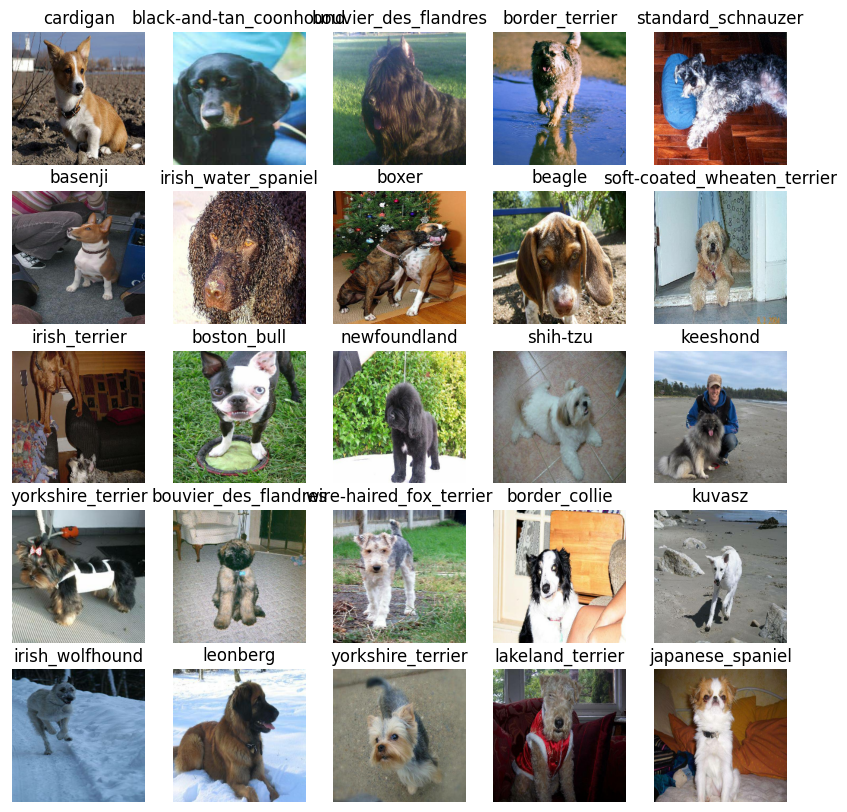

In [31]:
show_25_images(train_images, train_labels)

In [32]:
# validation
val_images, val_labels = next(val_data.as_numpy_iterator())

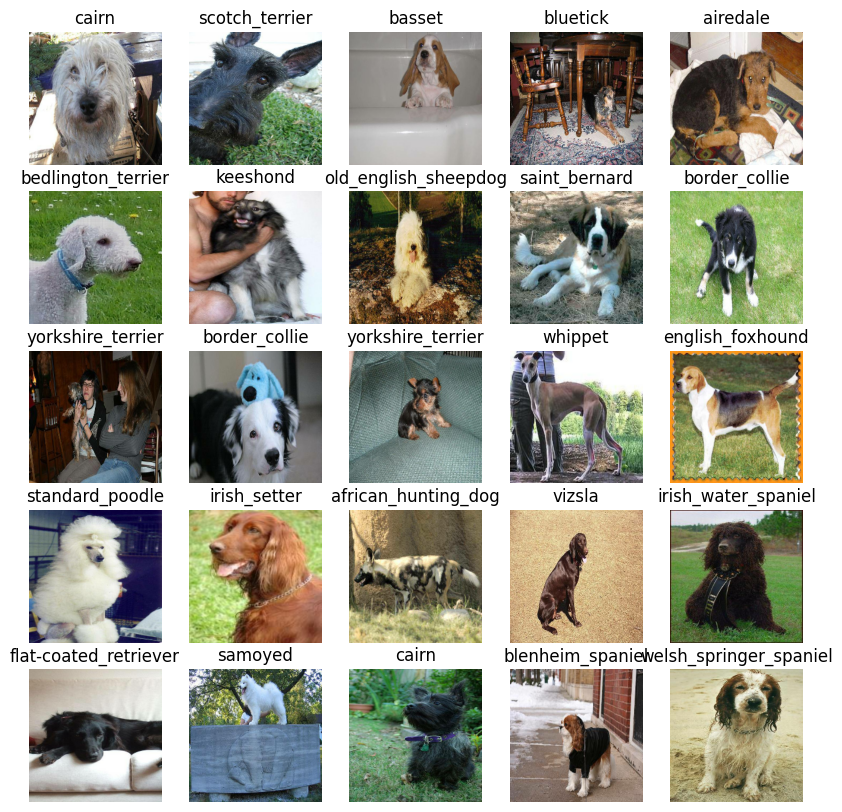

In [33]:
show_25_images(val_images, val_labels)

## Building a model



In [34]:
INPUT_SHAPE= [None, IMG_SIZE, IMG_SIZE, 3] # batch, hight, width, color channels
OUTPUT_SHAPE= len(unique_breeds) # 120
# Model URL from TF HUb
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [37]:
# Build a Keras model
def create_model(input_shape= INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url= MODEL_URL):
  # Model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url), # input later (layer 1)
      tf.keras.layers.Dense(units = output_shape,
                            activation = "softmax") # output layer (layer 2)
  ])

  # Complile the model
  model.compile(
      loss= tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics= ['accuracy']
  )

  # Build the model
  model.build(input_shape)
  
  return model

In [38]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________
